# Prophet 时间序列预测

prophet是facebook在2017年开源的强大的时间序列预测工具。

prophet(读作 ˈprɒfɪt)这个英文单词的意思是先知，预言家(没错，就是天黑请睁眼的那位😋)。顾名思义，它能够预测未来。

Prophet是一个设计精妙的单层的回归模型，特别适合对具有明显季节周期性(如气温，商品销量，交通流量等)的时间序列进行预测，并具有强大的解释性。
我们将简要介绍Prophet框架的算法原理，并以一个开源的能源消耗时间序列数据预测为例，展示prophet的使用方法和强大能力。



公众号**算法美食屋**后台回复关键词：**prophet**，获取本教程使用数据集下载链接~



## 〇，Prophet的原理概述

**prophet的优点：**

1， 拟合能力强。可以拟合时间序列数据中的趋势特性，周期特性，以及节假日时间/特殊事件影响等，可以返回置信区间作为预测结果。

2，对噪声鲁棒。趋势项中引入了changepoints，模型的参数量远远小于lstm等深度方案，不容易过拟合，收敛迅速。

3，模型解释性好。提供了强大的可视化分析辅助工具，便于分析趋势，不同周期，不同节假日/特殊事件 各自的贡献。


**prophet的缺点：**

1，不适用协变多维序列。prophet仅仅能够对单个时间序列建模(例如某地气温)，不能够对协变的多个序列同时建模(例如沪深300支股票走势)。

2，无法进行自动化复杂特征抽取。受prophet模型相对简单的假设空间的限制，它无法对输入特征进行交叉组合变换等自动化抽取操作。


**prophet的原理：** 

prophet是一个加法模型，将时间序列分解成 趋势项，周期项，节假日项/特殊事件影响，以及残差项的组合。

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t $$

【注：根据需要，也可以将 周期项 和 节假日项/特殊事件影响 设置为乘数，而非加数】

1，其中趋势项被拟合成 分段线性函数(默认) 或者 分段logistic函数(存在上下限的情形，如虫口模型，病毒传播等存在容量上限)。

2，周期项使用有限阶(通常对一个是4到8阶)的傅里叶级数进行拟合，大大减少了参数量，避免对噪声数据过拟合。

3，节假日项/特殊事件项 可以作为点特征或者区间特征引入，并支持自定义不同类型的节假日或事件，还可通过add_regressor引入其它已知序列作为特征，非常灵活。


参考文档:

官方文档：https://facebook.github.io/prophet/docs

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # For plots

## 一，准备数据

我们使用的数据集是美国能源消耗数据集进。该数据集包含了美国一家能源公司的长达数十年的能源消耗数据，数据分辨率为小时。

公众号**算法美食屋**后台回复关键词：**prophet**，获取`PJME_hourly.csv`数据集下载链接~



### 1，读取数据

In [75]:
dfdata = pd.read_csv('PJME_hourly.csv',
                   index_col=[0], parse_dates=[0])
dfdata.columns = ['y']  #将预测目标列名称改为y 
dfdata.index.name = 'ds'   #将时间序列名称改为ds 

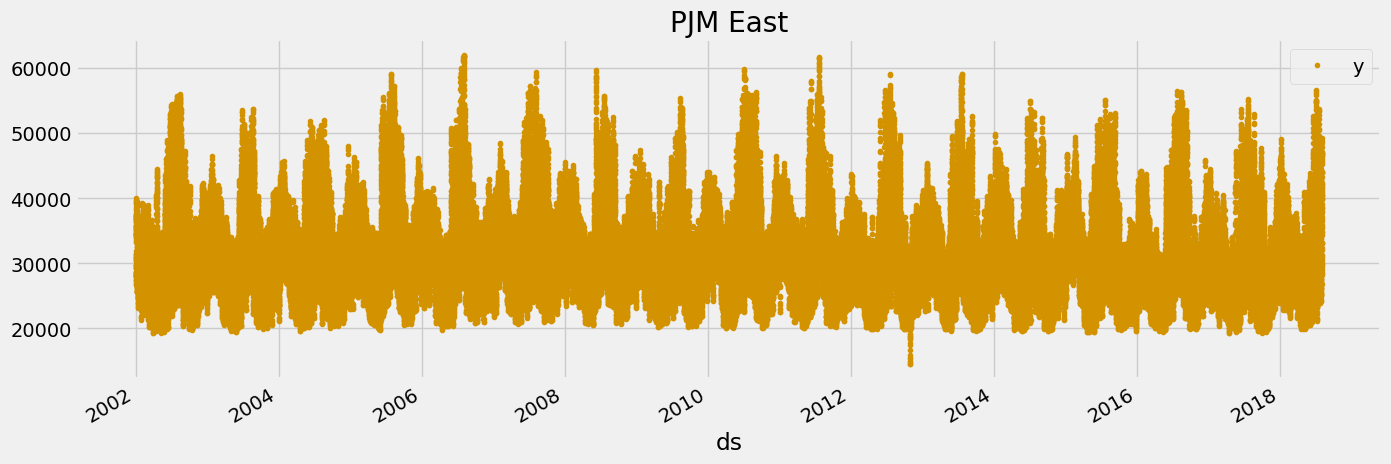

In [76]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
dfdata.plot(style='.', figsize=(15,5), color=color_pal[1], title='PJM East')
plt.show()

### 2, 数据eda


我们设计一些时间日期特征来查看数据的趋势

In [77]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week #df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(dfdata, label='y')

dfXy = pd.concat([X, y], axis=1)


In [78]:
# See our features and target
dfXy.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y
ds,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


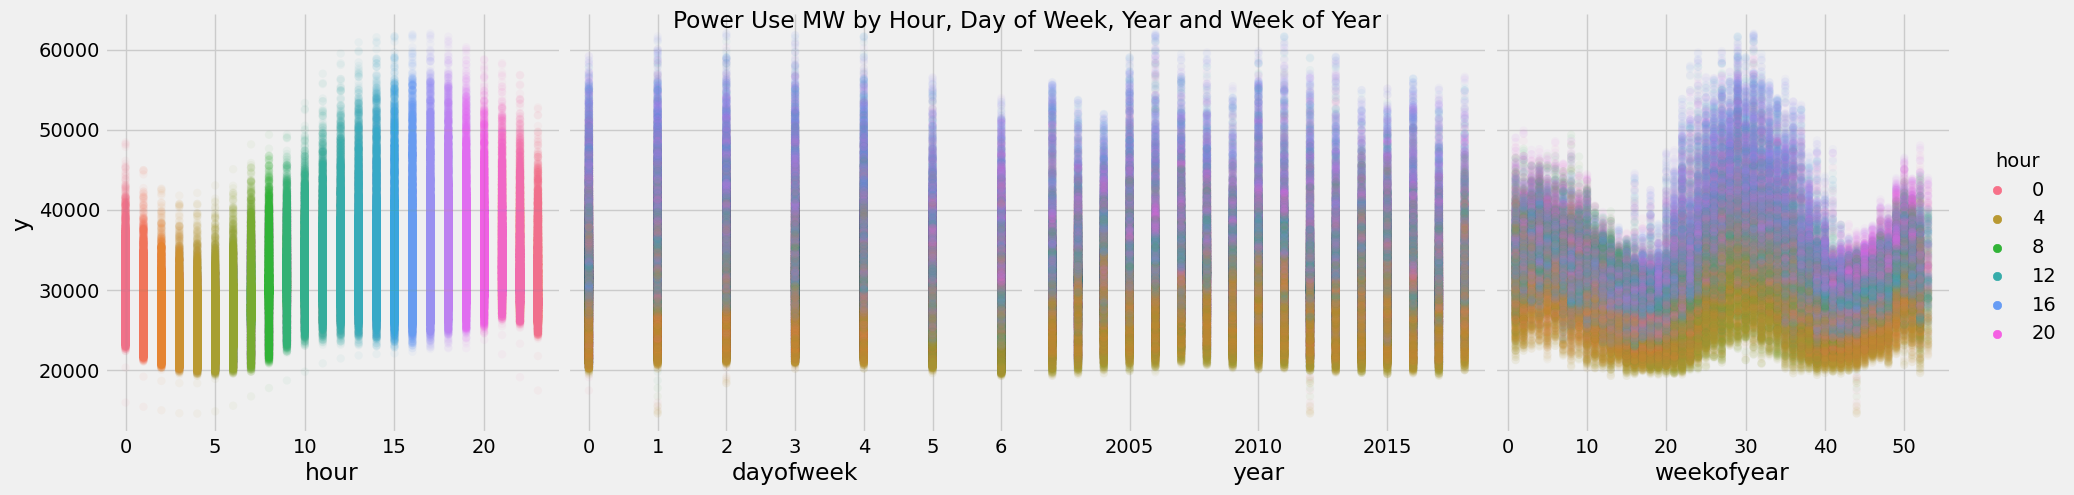

In [79]:
sns.pairplot(dfXy.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='y',
             kind='scatter',
             height=5,
             plot_kws={'alpha':0.05, 'linewidth':0},
             palette='husl'
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

### 3, 数据分割

In [81]:
split_date = '2015-01-01'
dftrain = dfdata.loc[dfdata.index <= split_date].copy()
dftest = dfdata.loc[dfdata.index > split_date].copy()

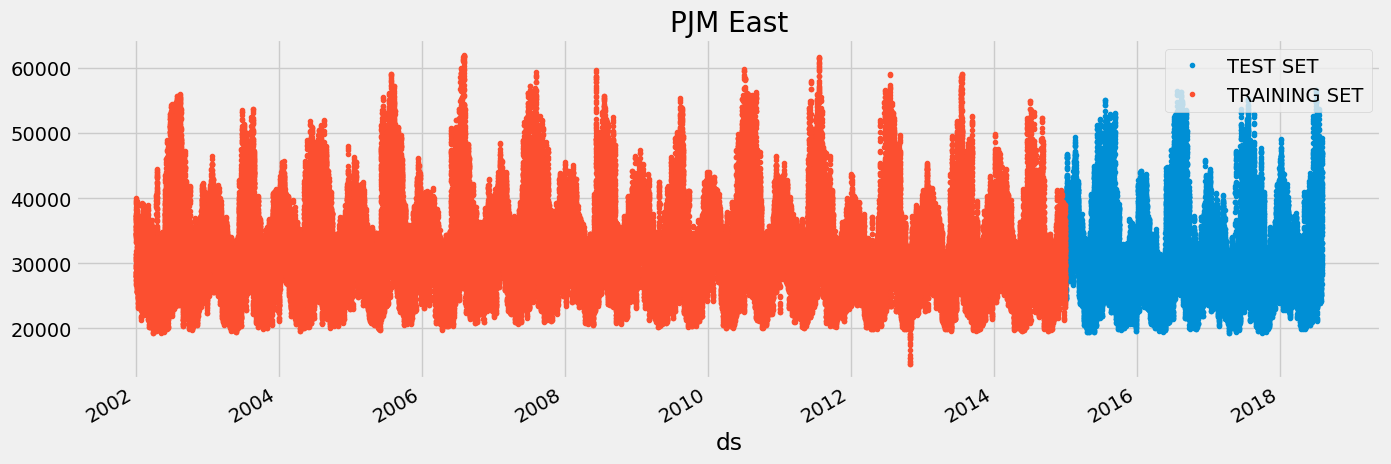

In [82]:
dftest \
    .rename(columns={'y': 'TEST SET'}) \
    .join(dftrain.rename(columns={'y': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

## 二，定义模型


In [166]:
from prophet import Prophet
# model = Prophet()  #使用默认参数

#1，趋势项相关设置

# model = Prophet(growth = 'logistic') #默认是linear
# model = Prophet(changepoints=['2020-01-01','2023-01-01']) #手工设置changepoints
# model = Prophet(n_changepoints=25) 
# model = Prophet(changepoint_range=0.8)
# model = Prophet(changepoint_prior_scale=0.05) #越大越容易转变趋势


#2，周期项相关设置

# model = Prophet(yearly_seasonality='auto')
# model = Prophet(weekly_seasonality=True)
# model = Prophet(daily_seasonality=False)
# model = Prophet(seasonality_mode='multiplicative') #默认是additive
# model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1) #手工添加周期项

#3，节假日项相关设置

# model.add_country_holidays(country_name='AU')
# model = Prophet(holidays=dfholidays,holidays_mode='multiplicative') 
# model.add_regressor('temperature') #使用温度特征作为一个回归项因子，需要在训练集和测试集中都知道


In [203]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
dfdata['date'] = dfdata.index.date
dfdata['is_holiday'] = dfdata.date.isin([d.date() for d in cal.holidays()])
dfholidays = dfdata.loc[dfdata['is_holiday']] \
    .reset_index() \
    .rename(columns={'Ddate':'ds'})
dfholidays['holiday'] = 'USFederalHoliday'
dfholidays = dfholidays.drop(['y','date','is_holiday'], axis=1)
dfholidays['ds'] = pd.to_datetime(dfholidays['ds'])

dfholidays.head()


,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [209]:
model = Prophet(holidays=dfholidays)  



## 三，训练模型

In [211]:
model.fit(dftrain.reset_index(), iter=10000, show_console=True)

16:47:09 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = optimize
Chain [1] optimize
Chain [1] algorithm = lbfgs (Default)
Chain [1] lbfgs
Chain [1] init_alpha = 0.001 (Default)
Chain [1] tol_obj = 9.9999999999999998e-13 (Default)
Chain [1] tol_rel_obj = 10000 (Default)
Chain [1] tol_grad = 1e-08 (Default)
Chain [1] tol_rel_grad = 10000000 (Default)
Chain [1] tol_param = 1e-08 (Default)
Chain [1] history_size = 5 (Default)
Chain [1] jacobian = 0 (Default)
Chain [1] iter = 10000
Chain [1] save_iterations = 0 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmp5fviu2ll/mgnwb4lc.json
Chain [1] init = /tmp/tmp5fviu2ll/mcv3hvtx.json
Chain [1] random
Chain [1] seed = 62419
Chain [1] output
Chain [1] file = /tmp/tmp5fviu2ll/prophet_model_beinyi9/prophet_model-20231123164709.csv
Chain [1] diagnostic_file =  (Default)
Chain [1] refresh = 100 (Default)
Chain [1] sig_figs = -1 (Default)
Chain [1] profile_file = profile.csv (Default)
Chain [1] num_threads = 1 (Default)
Chain [1] 
Chain [1] Initial log joint pr

16:49:02 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 2670        270384   0.000113925       154.677      0.9994      0.9994     3055
Chain [1] Optimization terminated normally:
Chain [1] Convergence detected: relative gradient magnitude is below tolerance
Chain [1] 


## 四，使用模型

In [212]:
# dftest = model.make_future_dataframe(periods=180)
dftest_fcst = model.predict(df=dftest.reset_index())


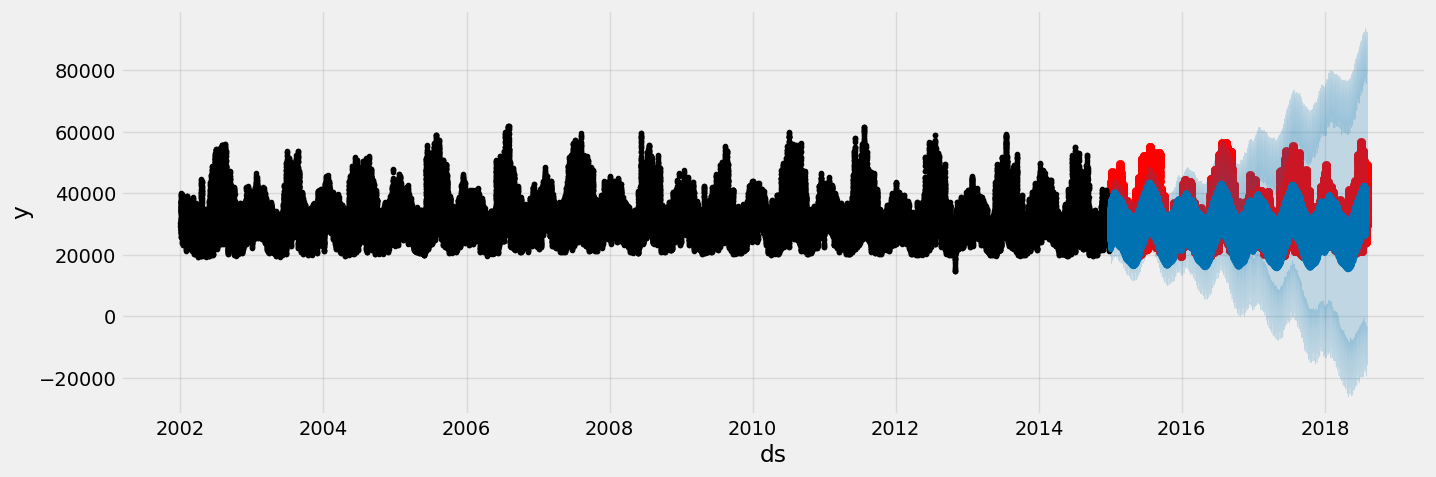

In [213]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dftest.index, dftest['y'], color='r') #真实值
fig = model.plot(dftest_fcst,
                 ax=ax) #预测值以及范围
plt.show()


In [220]:
# 加法模型结构
display(dftest_fcst.tail())
cols = [x for x in dftest_fcst.columns if 'lower' not in x and 'upper' not in x] 
print(cols)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
31434,2018-08-02 20:00:00,30095.186029,-4911.161849,90739.700612,-15775.001517,80368.182623,0.0,0.0,0.0,11181.206998,...,1024.602010,1024.602010,1024.602010,5705.501724,5705.501724,5705.501724,0.0,0.0,0.0,41276.393027
31435,2018-08-02 21:00:00,30095.148915,-4540.409843,90930.932449,-15777.969923,80372.334453,0.0,0.0,0.0,10406.866564,...,1010.476933,1010.476933,1010.476933,5700.486311,5700.486311,5700.486311,0.0,0.0,0.0,40502.015478
31436,2018-08-02 22:00:00,30095.111801,-5652.033847,89366.051804,-15780.938329,80376.486282,0.0,0.0,0.0,8776.260183,...,996.344360,996.344360,996.344360,5695.470183,5695.470183,5695.470183,0.0,0.0,0.0,38871.371983
31437,2018-08-02 23:00:00,30095.074686,-8565.880188,87210.179500,-15783.906735,80380.638111,0.0,0.0,0.0,6567.281811,...,982.024916,982.024916,982.024916,5690.453432,5690.453432,5690.453432,0.0,0.0,0.0,36662.356498
31438,2018-08-03 00:00:00,30095.037572,-11928.999346,85240.039199,-15786.875141,80384.789941,0.0,0.0,0.0,4240.628624,...,967.303696,967.303696,967.303696,5685.436149,5685.436149,5685.436149,0.0,0.0,0.0,34335.666196


['ds', 'trend', 'USFederalHoliday', 'additive_terms', 'daily', 'holidays', 'weekly', 'yearly', 'multiplicative_terms', 'yhat']


In [219]:
# yhat = trend+additive_terms
print((dftest_fcst['yhat']-dftest_fcst.eval('trend+additive_terms')).sum())

# additive_terms = daily+weekly+yearly+multiplicative_terms+USFederalHoliday
print((dftest_fcst['additive_terms']-dftest_fcst.eval('daily+weekly+yearly+multiplicative_terms+USFederalHoliday')).sum())


0.0
-9.681855317467125e-11


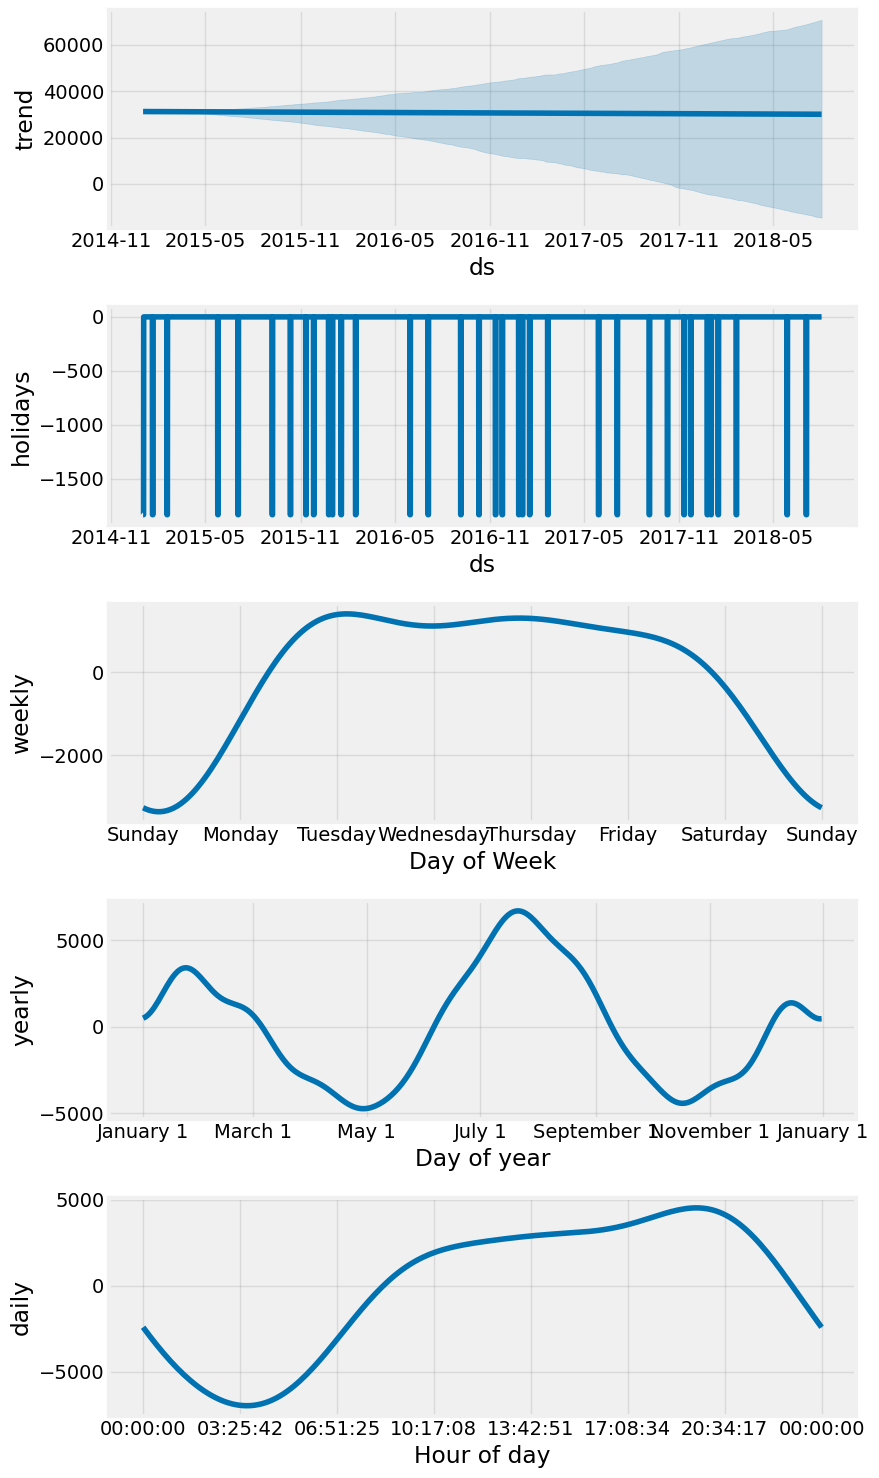

In [202]:
# model explaination
fig = model.plot_components(dftest_fcst)

## 五，评估模型

In [222]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



mse = mean_squared_error(y_true=dftest['y'],
                   y_pred=dftest_fcst['yhat'])

mae = mean_absolute_error(y_true=dftest['y'],
                   y_pred=dftest_fcst['yhat'])
mape = mean_absolute_percentage_error(y_true=dftest['y'],
                   y_pred=dftest_fcst['yhat'])

print('mse = ',mse)
print('mae = ',mae)
print('mape = ',mape)

mse =  43889420.377070874
mae =  5190.580798417535
mape =  16.5407058132873


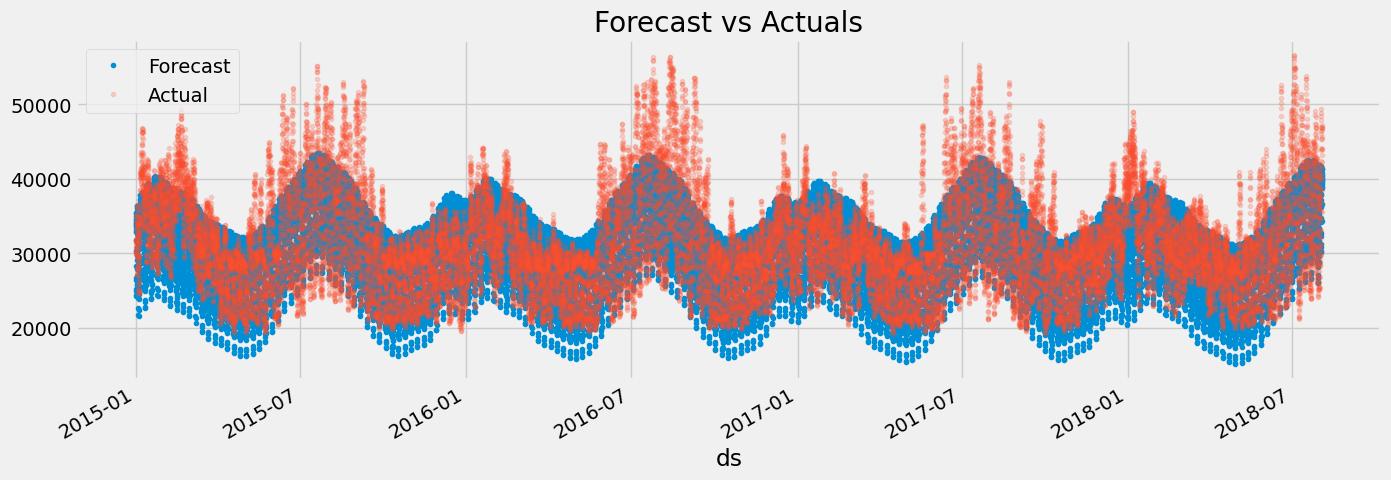

In [225]:
#真实值和预测值差异比较
ax = dftest_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
dftest['y'].plot(ax=ax,
                  style='.',
                  lw=0,
                  alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()


## 六，保存模型

In [228]:
import json 
from prophet.serialize import model_to_json, model_from_json
# save
with open('prophet_model.json', 'w') as md:    
    json.dump(model_to_json(model), md)
    
    
# load
with open('prophet_model.json', 'r') as md:   
    model_loaded = model_from_json(json.load(md))

/usr/local/lib/python3.8/dist-packages/prophet/serialize.py:172: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')



In [230]:
dftest 

,y
ds,
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
2015-12-31 05:00:00,22773.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [232]:
dftest_fcst = model_loaded.predict(dftest.reset_index())

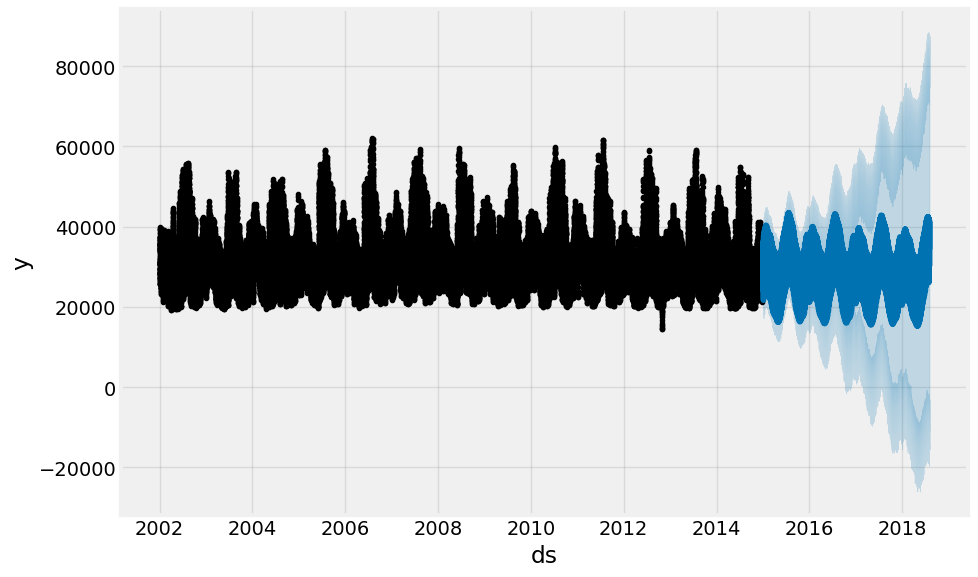

In [233]:
model_loaded.plot(dftest_fcst);